In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf                

2024-05-16 13:40:20.265679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 13:40:20.265781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 13:40:20.410450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# This size needed for EfficientNetB0
IMAGE_SIZE = (224, 224)

def load_data():
    datasets = ['/kaggle/input/face-expression-recognition-dataset/images/train/']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
#                 image = cv2.imread(img_path)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking 1k images from of each type
                # bcause Notebook getting out of memory error
                count = count + 1
                if count == 1000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

(images, labels) = load_data()[0]

Loading /kaggle/input/face-expression-recognition-dataset/images/train/


 14%|█▍        | 999/7164 [00:05<00:36, 170.55it/s]


In [3]:
# # Memory taken by array
print((images.nbytes/1024)/1024)

permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1)
train_images = train_images / 255.0 
test_images = test_images / 255.0

# # Memory taken by array
# (images.nbytes/1024)/1024

3695.671875


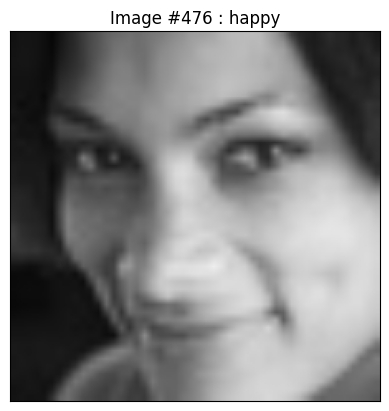

In [5]:
def display_random_image(class_names, images, labels):   
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

# Fine Tunning : Tune only top layer

In [6]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

In [7]:
inputs = Input(shape=(224, 224, 3))
base_model = VGG16(
    weights='imagenet', 
    input_tensor=inputs,
    include_top=False
    ) 

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(show_trainable=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 16)            │      8,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 16)            │          0 │   - 

 Total params: 14,725,063 (56.17 MB)

 Trainable params: 9,351 (36.53 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [8]:
history = model.fit(train_images, train_labels, epochs=10, validation_split = 0.2)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1556s 11s/step - accuracy: 0.1863 - loss: 2.0479 - val_accuracy: 0.2709 - val_loss: 1.8847
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1551s 11s/step - accuracy: 0.2979 - loss: 1.7653 - val_accuracy: 0.3089 - val_loss: 1.8221
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1525s 11s/step - accuracy: 0.3402 - loss: 1.6743 - val_accuracy: 0.3520 - val_loss: 1.7356
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1618s 11s/step - accuracy: 0.3551 - loss: 1.6513 - val_accuracy: 0.3581 - val_loss: 1.6562
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1596s 11s/step - accuracy: 0.3601 - loss: 1.6206 - val_accuracy: 0.3960 - val_loss: 1.6108
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1572s 11s/step - accuracy: 0.3755 - loss: 1.5618 - val_accuracy: 0.3762 - val_loss: 1.5935
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1565s 11s/step - accuracy: 0.3916 - loss: 1.5586 - val_accuracy: 0.3874 - val_loss: 1.5908
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1576s 11s/step - accuracy: 0.3970 - loss: 1

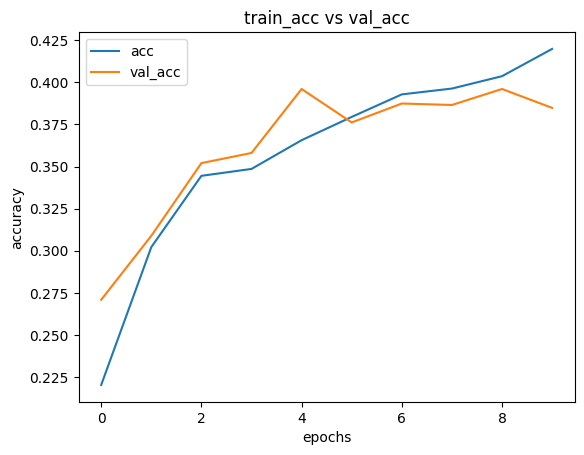

In [9]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend() 

# Fine tune entire model:Unfreeze base model

Unfreeze the base model and train the entire model end-to-end with a **low learning rate.** <br>**A very low learning rate helps to ensure that updates are small and gradual, preventing drastic changes to the model's learned features.**

In [10]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history = model.fit(train_images, train_labels, epochs=2, validation_split = 0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 16)            │      8,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 16)            │          0 │   - 

 Total params: 14,743,767 (56.24 MB)

 Trainable params: 14,724,039 (56.17 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 18,704 (73.07 KB)

Fitting the end-to-end model
Epoch 1/2
145/145 ━━━━━━━━━━━━━━━━━━━━ 4917s 34s/step - accuracy: 0.4159 - loss: 1.5025 - val_accuracy: 0.4081 - val_loss: 1.5627
Epoch 2/2
145/145 ━━━━━━━━━━━━━━━━━━━━ 4953s 34s/step - accuracy: 0.4573 - loss: 1.3696 - val_accuracy: 0.3572 - val_loss: 1.5982


In [13]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

21/21 ━━━━━━━━━━━━━━━━━━━━ 198s 9s/step


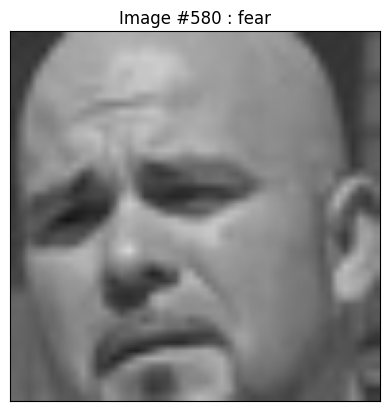

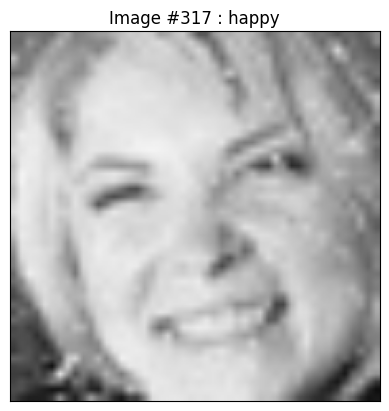

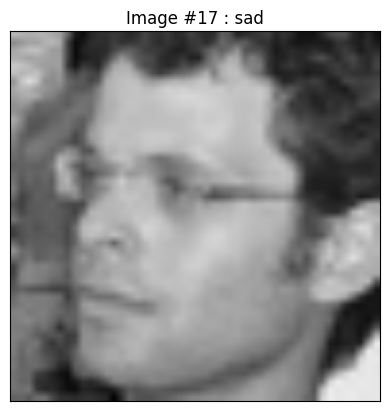

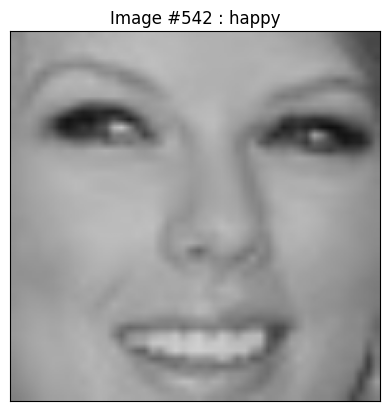

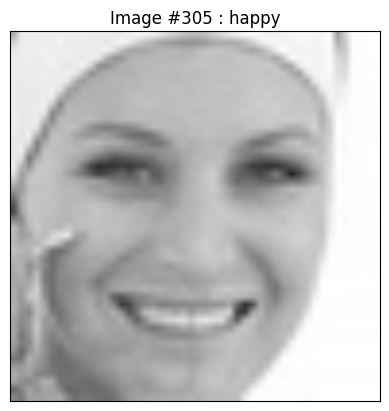

In [22]:
# Display Random Five predicted labels
for i in range(5):
    display_random_image(class_names, test_images, pred_labels) 

<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        IF YOU LIKED THE NOTEBOOK PLEASE DO UPVOTE!  
    </h2>
    </div>